##### *Seghe Momodu*
##### *November 3, 2020*

# **1. Introduction**

September was a good month in terms of traffic for Jumia. Many users
visited the app & website. Your head of CRM wants to leverage this and
has a good offer to share. But he wants to share this offer only with users
who are very likely to purchase in the next 15 days.

The objective of this analysis is to predict the users that will most likely purchase in the next 15 days.

# **2. Methodology**

In order to predict the customers likelihood to purchase, I have used a 2-part process. 

In the first part, I have used the RFM Model (Recency, Frquency, Monetary) to conduct a behavioural segmentation of the customers. After this was done, I used the clusters from each of Recency, Frequency and Monetary to create a new feature, **total score**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3. Data**

#### **Loading Required Libraries**

In [ ]:
# Import libraries
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np

# Do not show warnings
import warnings
warnings.filterwarnings('ignore')

# Import plotly for visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib import style
plt.style.use('ggplot')
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 12, 10
from yellowbrick.cluster import SilhouetteVisualizer

# Import machine learning related libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### Load Data

In [ ]:
# Read data from excel files

training = pd.read_excel('/content/drive/My Drive/Jumia/Jumia Data Scientist Case Study Data/case3_jumia_application.xlsx', sheet_name = 'training')
testing = pd.read_excel('/content/drive/My Drive/Jumia/Jumia Data Scientist Case Study Data/case3_jumia_application.xlsx', sheet_name = 'testing')

In [ ]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114999 entries, 0 to 114998
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   user_id                  114999 non-null  int64         
 1   app_user                 114999 non-null  int64         
 2   num_visits_past_30_d     114999 non-null  int64         
 3   num_add_to_cart          114999 non-null  int64         
 4   num_product_views        114999 non-null  int64         
 5   recency_visit            114999 non-null  int64         
 6   valid_orders             93647 non-null   float64       
 7   NMV                      93647 non-null   float64       
 8   last_order_date          78718 non-null   datetime64[ns]
 9   last_order_number_items  78718 non-null   float64       
 10  cod_customer_gender      85777 non-null   object        
 11  category1_reco           105352 non-null  object        
 12  one             

In [ ]:
# Check for missing values

training.isna().sum()

user_id                        0
app_user                       0
num_visits_past_30_d           0
num_add_to_cart                0
num_product_views              0
recency_visit                  0
valid_orders               21352
NMV                        21352
last_order_date            36281
last_order_number_items    36281
cod_customer_gender        29222
category1_reco              9647
one                            0
food                           0
pay                            0
ordered_14d                    0
dtype: int64

In [ ]:
training['last_order_date'] = pd.to_datetime(training['last_order_date'], format = '%Y-%m-%d', errors = 'ignore')

In [ ]:
training['last_order_date'].describe()

count                   78718
unique                   1845
top       2020-09-30 00:00:00
freq                     2469
first     2012-11-19 00:00:00
last      2020-09-30 00:00:00
Name: last_order_date, dtype: object

In order to predict the customers that would purchase in the next 15 days, I have extracted the customers' behavioural data from the last three months, between **2020-06-01** and **2020-09-09**. 

In [ ]:
training_3m = training[(training['last_order_date'] >= datetime(2020,6,1)) & (training['last_order_date'] <= datetime(2020,9,1))].reset_index(drop=True)

I have created a new dataframe, training user whaich will hold a user-level feature set for the predictions.

In [ ]:
training_user = pd.DataFrame(training_3m['user_id'].unique())
training_user.columns = ['user_id']

# Applying  transformation on the testing data
testing_user = pd.DataFrame(testing['user_id'].unique())
testing_user.columns = ['user_id']

In [ ]:
training_3m.isna().sum()

user_id                       0
app_user                      0
num_visits_past_30_d          0
num_add_to_cart               0
num_product_views             0
recency_visit                 0
valid_orders                  0
NMV                           0
last_order_date               0
last_order_number_items       0
cod_customer_gender        5174
category1_reco              153
one                           0
food                          0
pay                           0
ordered_14d                   0
dtype: int64

# **4. Feature Engineering**

### **Recency**

In [ ]:
recency = training_3m[['user_id', 'recency_visit']].reset_index(drop = True)

# Applying  transformation on the testing data
recency_test = testing[['user_id', 'recency_visit']].reset_index(drop = True)

In [ ]:
recency.columns = ['user_id', 'recency']

# Applying  transformation on the testing data
recency_test.columns = ['user_id', 'recency_test']

In [ ]:
training_user = pd.merge(training_user, recency, on = 'user_id')

# Applying transformation on the testing data
testing_user = pd.merge(testing_user, recency_test, on = 'user_id')

In [ ]:
training_user['recency'].describe()

count    23769.000000
mean         8.278177
std          8.034187
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max         30.000000
Name: recency, dtype: float64

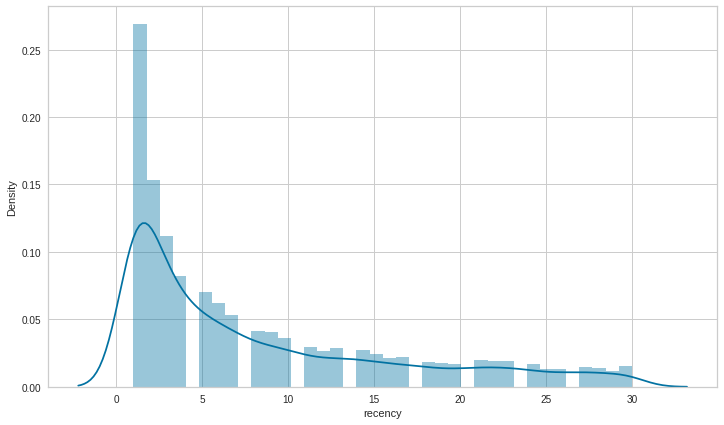

In [ ]:
plt.figure(figsize = (12, 7))
sns.distplot(training_user.query('recency <= 30')['recency'])

The Silhouette Analysis has been used to find the optimal number of clusters for the K-Means Clustering model.

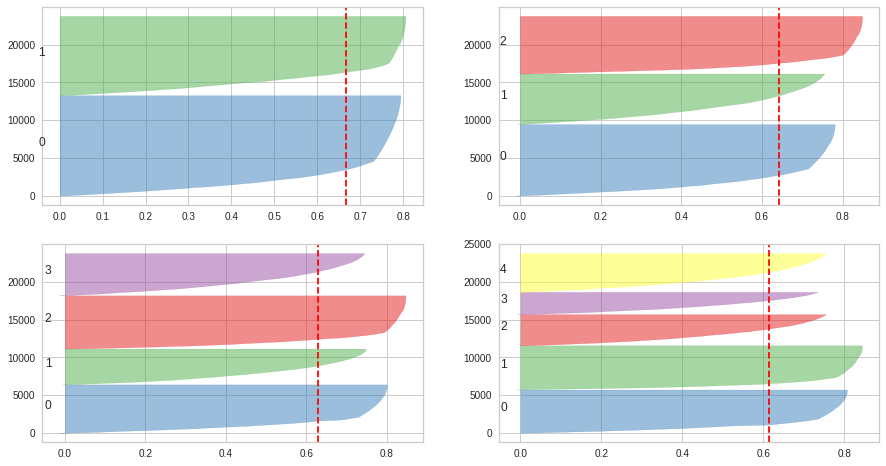

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
for i in [2, 3, 4, 5]:
    
    # Create KMeans instance for different number of clusters
    
    km = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state=42)
    q, mod = divmod(i, 2)
    
    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
   
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(training_user)

The  optimal number of clusters is 2.

In [ ]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(training_user[['recency']])
training_user['recency_cluster'] = kmeans.predict(training_user[['recency']])

# Applying  transformation on the testing data
kmeans.fit(testing_user[['recency_test']])
testing_user['recency_cluster'] = kmeans.predict(testing_user[['recency_test']])

In [ ]:
# Organise the clusters in ascending order

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [ ]:
training_user = order_cluster('recency_cluster', 'recency', training_user, False)

# Applying  transformation on the testing data
testing_user = order_cluster('recency_cluster', 'recency_test', testing_user, False)

In [ ]:
training_user.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,6074.0,20.338657,5.211995,13.0,16.0,20.0,24.0,30.0
1,17695.0,4.138288,3.211090,1.0,1.0,3.0,6.0,12.0


### **Frequency**

In [ ]:
frequency = training_3m[['user_id', 'num_visits_past_30_d']].reset_index(drop = True)
frequency.columns = ['user_id', 'frequency']

# Applying  transformation on the testing data
frequency_test = testing[['user_id', 'num_visits_past_30_d']].reset_index(drop = True)
frequency_test.columns = ['user_id', 'frequency_test']

In [ ]:
training_user = pd.merge(training_user, frequency, on = 'user_id')

# Applying  transformation on the testing data
testing_user = pd.merge(testing_user, frequency_test, on = 'user_id')

In [ ]:
training_user['frequency'].describe()

count    23769.000000
mean         9.259119
std         10.877034
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        276.000000
Name: frequency, dtype: float64

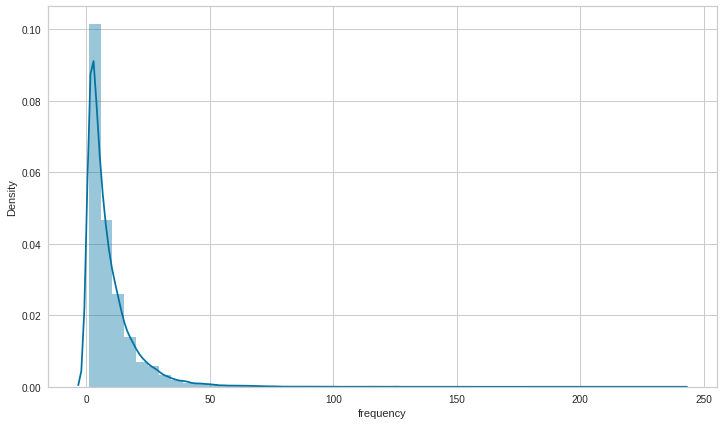

In [ ]:
plt.figure(figsize = (12, 7))
sns.distplot(training_user.query('frequency < 276')['frequency'])

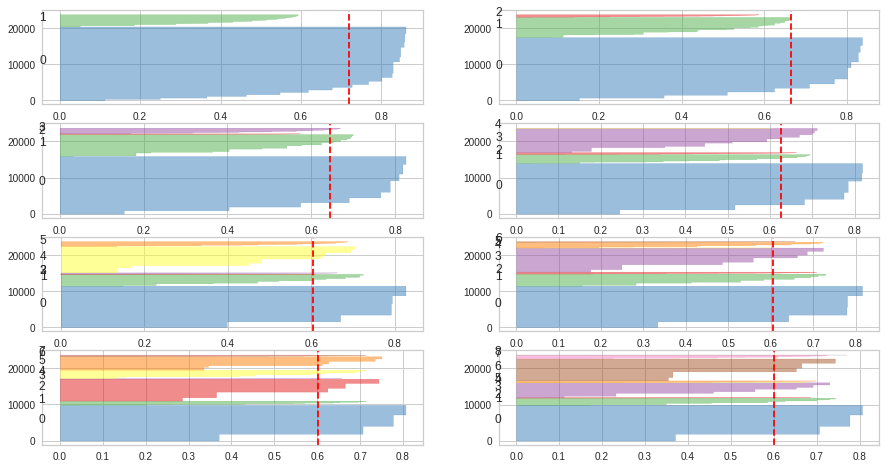

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 8))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    
    # Create KMeans instance for different number of clusters

    km = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state=42)
    q, mod = divmod(i, 2)
    
    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
    
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(training_user[['frequency']])

8 was chosen as the optimal number of clusters.

In [ ]:
kmeans = KMeans(n_clusters = 8)
kmeans.fit(training_user[['frequency']])
training_user['frequency_cluster'] = kmeans.predict(training_user[['frequency']])

# Applying  transformation on the testing data
kmeans.fit(testing_user[['frequency_test']])
testing_user['frequency_cluster'] = kmeans.predict(testing_user[['frequency_test']])

In [ ]:
training_user = order_cluster('frequency_cluster', 'frequency', training_user, False)

# Applying  transformation on the testing data
testing_user = order_cluster('frequency_cluster', 'frequency_test', testing_user, False)

In [ ]:
training_user.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,2.0,257.500000,26.162951,239.0,248.25,257.5,266.75,276.0
1,32.0,114.625000,20.750049,90.0,96.75,111.5,125.00,167.0
2,188.0,63.361702,9.152132,52.0,56.00,61.0,68.00,88.0
3,708.0,38.774011,5.491905,32.0,34.00,38.0,42.00,51.0
4,1592.0,25.035804,3.042849,21.0,22.00,25.0,28.00,31.0
5,3119.0,15.871433,2.268071,13.0,14.00,16.0,18.00,20.0
6,6663.0,8.515083,1.981384,6.0,7.00,8.0,10.00,12.0
7,11465.0,2.654775,1.388305,1.0,1.00,2.0,4.00,5.0


### **Monetary**

In [ ]:
monetary = training_3m[['user_id', 'NMV']]
monetary = monetary.groupby('user_id').sum().reset_index()
monetary.columns = ['user_id', 'monetary']

In [ ]:
# Applying  transformation on the testing data
monetary_test = testing[['user_id', 'NMV']]
monetary_test = monetary_test.groupby('user_id').sum().reset_index()
monetary_test.columns = ['user_id', 'monetary_test']

In [ ]:
training_user = pd.merge(training_user, monetary, on = 'user_id')

# Applying  transformation on the testing data
testing_user = pd.merge(testing_user, monetary_test, on = 'user_id')

In [ ]:
training_user['monetary'].describe()

count     23769.000000
mean        554.690024
std        4755.408146
min           0.000000
25%          39.840000
50%         141.110000
75%         446.650000
max      490835.040000
Name: monetary, dtype: float64

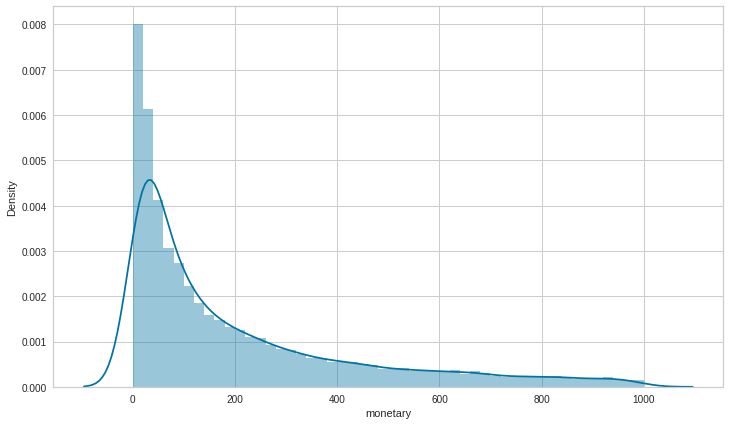

In [ ]:
plt.figure(figsize = (12, 7))
sns.distplot(training_user.query('monetary < 1000')['monetary'])

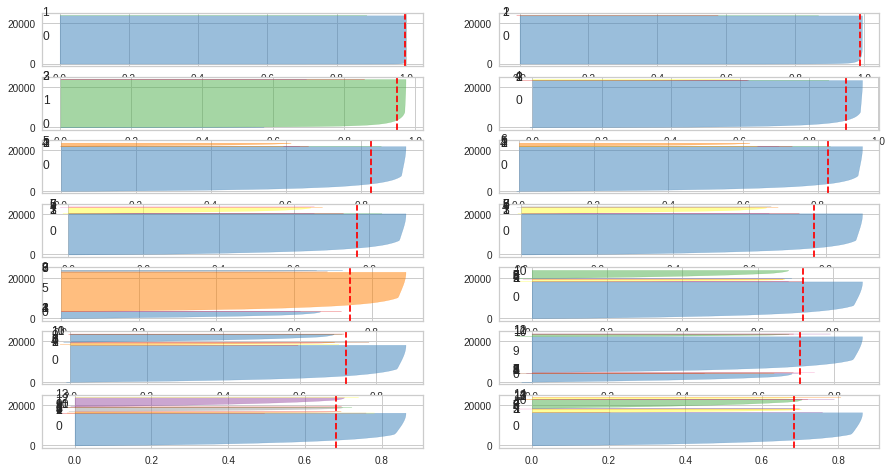

In [ ]:
fig, ax = plt.subplots(7, 2, figsize = (15, 8))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:

    # Create KMeans instance for different number of clusters
    
    km = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)
    
    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
    
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(training_user[['monetary']])

In [ ]:
kmeans = KMeans(n_clusters = 9)
kmeans.fit(training_user[['monetary']])
training_user['monetary_cluster'] = kmeans.predict(training_user[['monetary']])

# Applying  transformation on the testing data 
kmeans.fit(testing_user[['monetary_test']])
testing_user['monetary_cluster'] = kmeans.predict(testing_user[['monetary_test']])

In [ ]:
training_user = order_cluster('monetary_cluster', 'monetary', training_user, True)

# Applying  transformation on the testing data
testing_user = order_cluster('monetary_cluster', 'monetary_test', testing_user, True)

In [ ]:
# The number of clusters have been collapsed into 4 clusters, with the largest cluster being 0, and the smallest being 1, with 2 customers. 
training_user.loc[training_user['monetary_cluster'] > 4, 'monetary_cluster'] = 4

# Applying  transformation on the testing data
testing_user.loc[testing_user['monetary_cluster'] > 4, 'monetary_cluster'] = 4

In [ ]:
training_user.groupby('monetary_cluster')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,20331.0,180.861314,195.778841,0.00,32.080,100.60,265.3200,812.86
1,2889.0,1460.043094,575.927385,813.09,998.450,1280.37,1776.4200,3126.30
2,427.0,4817.113489,1418.278353,3130.68,3656.530,4398.59,5719.7000,8733.12
3,102.0,12784.668333,3582.880602,9007.29,9799.420,11848.94,14642.6275,23319.43
4,20.0,96416.384000,130097.936109,25495.29,33963.025,44956.74,89053.7625,490835.04


### **Overall Segmentation with RFM Score**

In [ ]:
training_user['RFM_score'] = training_user['recency_cluster'] + training_user['frequency_cluster'] + training_user['monetary_cluster']

# Applying  transformation on the testing data
testing_user['RFM_score'] = testing_user['recency_cluster'] + testing_user['frequency_cluster'] + testing_user['monetary_cluster']

In [ ]:
total_segment1 = training_user.groupby('RFM_score')['recency', 'frequency', 'monetary'].mean()

# Applying  transformation on the testing data
total_segment2 = testing_user.groupby('RFM_score')['recency_test', 'frequency_test', 'monetary_test'].mean()

In [ ]:
training_user['segment']  = 'Low-Value'
training_user.loc[training_user['RFM_score'] > 2, 'segment'] = 'Mid-Value' 
training_user.loc[training_user['RFM_score'] > 7, 'segment'] = 'High-Value'

In [ ]:
training_user1 = training_user[['user_id', 'RFM_score']]

# Applying  transformation on the testing data
testing_user1 = testing_user[['user_id', 'RFM_score']]

In [ ]:
training_new = pd.merge(training_user1, training_3m, on = 'user_id')

# Applying  transformation on the testing data
testing_new = pd.merge(testing_user1, testing, on = 'user_id')

I have created a new feature, **days_to_30_September** from the date feature by subtracting the last day, **2020-09-30** from the last_order_date to get the number of days in between.

In [ ]:
last_day = '2020-09-30'

#Convert last_day to datatime
last_day = pd.to_datetime(last_day, format = '%Y-%m-%d')

# Subtract last_day from last_order_date to get days in between
training_new['days_to_30_september'] = (last_day - training_new['last_order_date']).dt.days
training_new = training_new.drop(columns=['last_order_date'])

# Applying transformation on the testing data
testing_new['days_to_30_september'] = (last_day - testing_new['last_order_date']).dt.days
testing_new = testing_new.drop(columns=['last_order_date'])

In [ ]:
# Dropped the rows with NaN values in the cod_customer_gender and category1_reco columns

training_new_copy = training_new.copy()
training_new.dropna(subset = ['cod_customer_gender', 'category1_reco'], inplace = True)

# Applying  transformation on the testing data
testing_new_copy = testing_new.copy()
testing_new.dropna(subset = ['cod_customer_gender', 'category1_reco'], inplace = True)

In [ ]:
# Encoding the categorical columns

training_new_dummies = [pd.get_dummies(training_new['cod_customer_gender'], prefix = 'cod_customer_gender', prefix_sep = '_'), 
                        pd.get_dummies(training_new['category1_reco'], prefix = 'category1_reco', prefix_sep = '_'), 
                        pd.get_dummies(training_new['one'], prefix = 'one', prefix_sep = '_'),
                        pd.get_dummies(training_new['food'], prefix = 'food', prefix_sep = '_'), 
                        pd.get_dummies(training_new['pay'], prefix = 'pay', prefix_sep = '_')]


# Applying  transformation on the testing data
testing_new_dummies = [pd.get_dummies(testing_new['cod_customer_gender'], prefix = 'cod_customer_gender', prefix_sep = '_'), 
                        pd.get_dummies(testing_new['category1_reco'], prefix = 'category1_reco', prefix_sep = '_'), 
                        pd.get_dummies(testing_new['one'], prefix = 'one', prefix_sep = '_'),
                        pd.get_dummies(testing_new['food'], prefix = 'food', prefix_sep = '_'), 
                        pd.get_dummies(testing_new['pay'], prefix = 'pay', prefix_sep = '_')]                        

In [ ]:
training_new_dummies = pd.concat(training_new_dummies, axis = 1)

# Applying  transformation on the testing data
testing_new_dummies = pd.concat(testing_new_dummies, axis = 1)

In [ ]:
# Extract the numerical features into a dataframe

training_new1 = training_new[['RFM_score', 'app_user', 'num_visits_past_30_d', 
                      'num_add_to_cart', 'num_product_views', 'recency_visit', 
                      'days_to_30_september', 'valid_orders', 'NMV', 'last_order_number_items', 'ordered_14d']]

# Applying  transformation on the testing data
testing_new1 = testing_new[['RFM_score', 'app_user', 'num_visits_past_30_d', 
                            'num_add_to_cart_30_d', 'num_product_views_30_d', 'recency_visit', 
                            'days_to_30_september', 'valid_orders', 'NMV', 'last_order_number_items', 'ordered_14d']]

In [ ]:
# Concatenate the encoded featureswith the numerical features in a new dataframe

training_new2 = pd.concat([training_new1, training_new_dummies], axis = 1)

# Applying  transformation on the testing data
testing_new2 = pd.concat([testing_new1, testing_new_dummies], axis = 1)

### Feature Scaling with MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(training_new2.values)

# Applying  transformation on the testing data
scaled1 = scaler.fit_transform(testing_new2.values)

In [ ]:
# Convert the scaled numpy array into a dataframe

training_data = pd.DataFrame(data = scaled[:, :], columns = ['RFM_score', 'app_user', 'num_visits_past_30_d', 
                                                             'num_add_to_cart', 'num_product_views', 'recency_visit', 
                                                             'days_to_30_september', 'valid_orders', 'NMV', 
                                                             'last_order_number_items', 'cod_customer_gender_female', 
                                                             'cod_customer_gender_male', 'category1_reco_Baby_Kids', 
                                                             'category1_reco_Electronics', 'category1_reco_Grocery', 
                                                             'category1_reco_Health_Beauty', 'category1_reco_Home_Living', 
                                                             'category1_reco_Men_Fashion', 'category1_reco_Mobile_Tablet', 
                                                             'category1_reco_Others', 'category1_reco_Sports', 
                                                             'category1_reco_Women_Fashion', 'one_False', 'one_True', 'food_False', 
                                                             'food_True', 'pay_False', 'pay_True', 'ordered_14d'])


# Applying  transformation on the testing data
testing_data = pd.DataFrame(data = scaled[:, :], columns = ['RFM_score', 'app_user', 'num_visits_past_30_d', 
                                                             'num_add_to_cart_30_d', 'num_product_views_30_d', 'recency_visit', 
                                                             'days_to_30_september', 'valid_orders', 'NMV', 
                                                             'last_order_number_items', 'cod_customer_gender_female', 
                                                             'cod_customer_gender_male', 'category1_reco_Baby_Kids', 
                                                             'category1_reco_Electronics', 'category1_reco_Grocery', 
                                                             'category1_reco_Health_Beauty', 'category1_reco_Home_Living', 
                                                             'category1_reco_Men_Fashion', 'category1_reco_Mobile_Tablet', 
                                                             'category1_reco_Others', 'category1_reco_Sports', 
                                                             'category1_reco_Women_Fashion', 'one_False', 'one_True', 'food_False', 
                                                             'food_True', 'pay_False', 'pay_True', 'ordered_14d'])

In [ ]:
training_data1 = pd.concat([training_new[['user_id']], training_data], axis = 1)

# Applying  transformation on the testing data
testing_data1 = pd.concat([testing_new[['user_id']], testing_data], axis = 1)

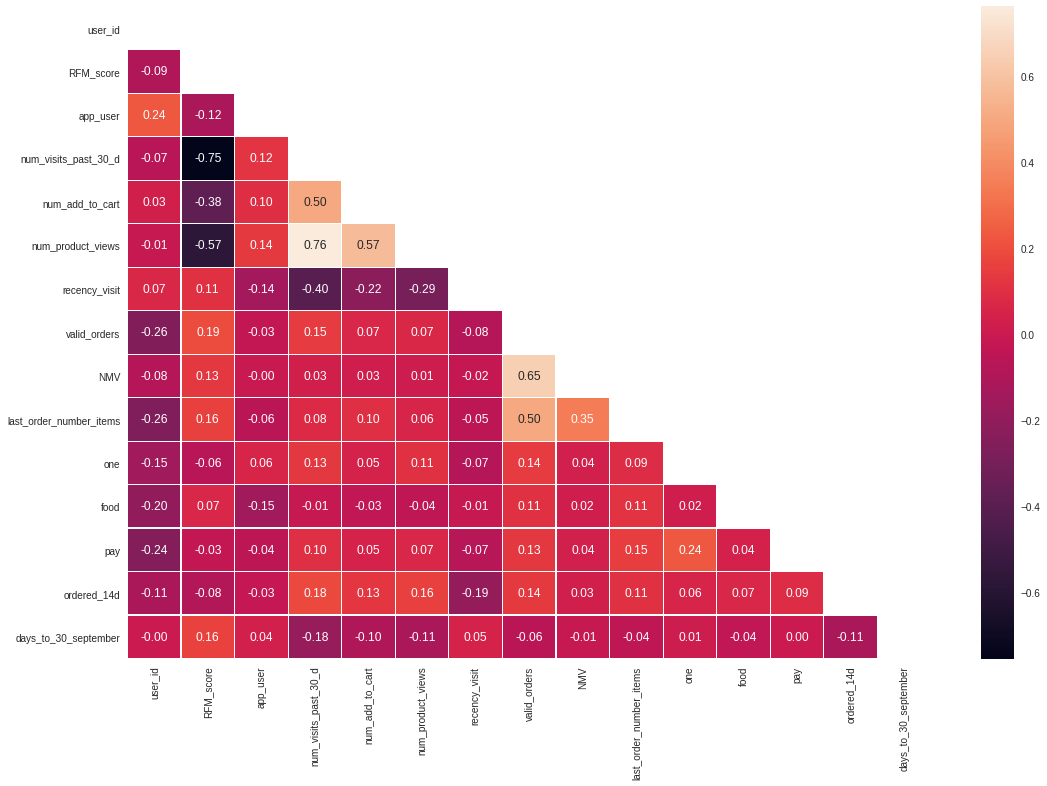

In [ ]:
corr = np.triu(training_new.corr())
plt.figure(figsize = (18, 12))
sns.heatmap(training_new.corr(), annot = True, linewidths = 0.2, fmt = '.2f', mask = corr)

The num_visits_30_d has the highest correlation with the RFM_score. Otherwise there is hardly any collinearity between the features.

In [ ]:
y = training_data['ordered_14d']
X = training_data[['RFM_score', 'app_user', 'num_visits_past_30_d', 'num_add_to_cart', 'num_product_views', 'recency_visit', 
                   'days_to_30_september', 'valid_orders', 'NMV', 'last_order_number_items', 'cod_customer_gender_female', 
                   'cod_customer_gender_male', 'category1_reco_Baby_Kids', 'category1_reco_Electronics', 'category1_reco_Grocery', 
                   'category1_reco_Health_Beauty', 'category1_reco_Home_Living', 'category1_reco_Men_Fashion', 'category1_reco_Mobile_Tablet', 
                   'category1_reco_Others', 'category1_reco_Sports', 'category1_reco_Women_Fashion', 'one_False', 
                   'one_True', 'food_False', 'food_True', 'pay_False', 'pay_True']]


# Applying  transformation on the testing data
y1 = testing_data['ordered_14d']
X1 = testing_data[['RFM_score', 'app_user', 'num_visits_past_30_d', 'num_add_to_cart_30_d', 'num_product_views_30_d', 'recency_visit', 
                   'days_to_30_september', 'valid_orders', 'NMV', 'last_order_number_items', 'cod_customer_gender_female', 
                   'cod_customer_gender_male', 'category1_reco_Baby_Kids', 'category1_reco_Electronics', 'category1_reco_Grocery', 
                   'category1_reco_Health_Beauty', 'category1_reco_Home_Living', 'category1_reco_Men_Fashion', 'category1_reco_Mobile_Tablet', 
                   'category1_reco_Others', 'category1_reco_Sports', 'category1_reco_Women_Fashion', 'one_False', 
                   'one_True', 'food_False', 'food_True', 'pay_False', 'pay_True']]

### Train-Test(Validation) split

In [ ]:
# Splitting data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Dimensionality Reduction with PCA

The number of features has increased to 30 features. To reduce our models' susceptibelity to the curse of dimensionality, and thus overfitting; I shall use Principal Component Analysis (PCA) to compress the feature space into 4 principal components.

In [ ]:
# Instantiate PCA
pca = PCA(n_components=4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Applying  transformation on the testing data
X1_ = pca.fit_transform(X1)

It can be seen that first principal component is responsible for 21.12% variance. Similarly, the second principal component causes 16.02% variance in the dataset. 

In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.21128166, 0.16022635, 0.10050147, 0.09367527])

# **5. Model Development**

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))

In [ ]:
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 42)
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    print(name, cv_result)

LR [0.86939722 0.88098918 0.86707883 0.88012374 0.87470998 0.87006961
 0.8391338  0.87316319 0.85769528 0.86929621]
NB [0.86939722 0.88098918 0.86707883 0.88012374 0.87470998 0.87006961
 0.8391338  0.87316319 0.85769528 0.86929621]
RF [0.99690881 0.9984544  0.99768161 0.99845321 0.99845321 0.99458623
 0.99458623 0.99690642 0.99458623 0.99767981]
XGB [0.98068006 0.98531685 0.97758887 0.98221191 0.9837587  0.97602475
 0.97525135 0.97525135 0.97370456 0.97911833]
KNN [0.99304482 0.99613601 0.99072643 0.99535963 0.99690642 0.99149265
 0.98839907 0.99226605 0.98762568 0.99458623]


Based the performance of the the Random Forest Classifier, this is the algorithm that will be used for the prediction.

In [ ]:
RF_model = XGBClassifier().fit(X_train, y_train)

print('Accuracy of Random Forest Classifier on training set: {:.4f}'
       .format(RF_model.score(X_train, y_train)))
print('Accuracy of Random Forest Classifier on test set: {:.4f}'
       .format(RF_model.score(X_test, y_test)))

Accuracy of Random Forest Classifier on training set: 0.9816
Accuracy of Random Forest Classifier on test set: 0.9744


In [ ]:
y_pred = RF_model.predict(X_test)
print(y_pred)

[1. 1. 0. ... 1. 1. 1.]


In [ ]:
probabilities = RF_model.predict_proba(X_test)
probabilities

array([[0.01425374, 0.98574626],
       [0.01370299, 0.986297  ],
       [0.9887774 , 0.01122263],
       ...,
       [0.01085377, 0.98914623],
       [0.05478579, 0.9452142 ],
       [0.05478579, 0.9452142 ]], dtype=float32)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89       733
         1.0       0.97      1.00      0.99      4810

    accuracy                           0.97      5543
   macro avg       0.98      0.90      0.94      5543
weighted avg       0.98      0.97      0.97      5543



In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 592,  141],
       [   1, 4809]])

# **Modelling the Testing Set**

In [ ]:
RF_model = XGBClassifier().fit(X1_, y1)

print('Accuracy of Random Forest Classifier on testing set: {:.4f}'
       .format(RF_model.score(X1_, y1)))

Accuracy of Random Forest Classifier on testing set: 0.9836


In [ ]:
y1_pred = RF_model.predict(X1_)
print(y1_pred)

[1. 0. 1. ... 1. 1. 1.]


In [ ]:
probabilities1 = RF_model.predict_proba(X1_)
probabilities1[1]

array([0.8670746, 0.1329254], dtype=float32)

In [ ]:
print(classification_report(y1, y1_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      2438
         1.0       0.98      1.00      0.99     16038

    accuracy                           0.98     18476
   macro avg       0.99      0.94      0.96     18476
weighted avg       0.98      0.98      0.98     18476



In [ ]:
confusion_matrix(y1, y1_pred)

array([[ 2135,   303],
       [    0, 16038]])

In [ ]:
testing_data['ordered_14d'] = y1_pred
#testing_data['probabilities'] = probabilities1[1]

In [ ]:
testing_data['user_id'] = testing['user_id']

In [ ]:
testing_final = testing_data[['user_id', 'ordered_14d']]
testing_final

,user_id,ordered_14d
0,7144625,1.0
1,1894232,0.0
2,9647766,1.0
3,2411875,1.0
4,903200,1.0
...,...,...
18471,3661219,1.0
18472,5328179,1.0
18473,7265705,1.0
18474,3393945,1.0
